CarND Term 1 Project 5: Vehicle Detection
===

### Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a Linear SVM classifier
* [Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.]
* **Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.**
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### Code section 1: Load the training data
The full training data provided for this project contains a roughly even mix of car and non-car images. In this pipeline I am using a random subset of these images.

In [1]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time

%matplotlib inline

# Divide up into cars and notcars
images = glob.glob('vehicles/**/*.png', recursive=True)
cars = []
for image in images:
    cars.append(image)
print('# of cars:   ',len(cars))

images = glob.glob('non-vehicles/**/*.png', recursive=True)
notcars = []
for image in images:
    notcars.append(image)
print('# of notcars:',len(notcars))

# of cars:    8792
# of notcars: 8968


### Code section 2: Display examples from the training dataset
Display a few examples of both car and non-car images

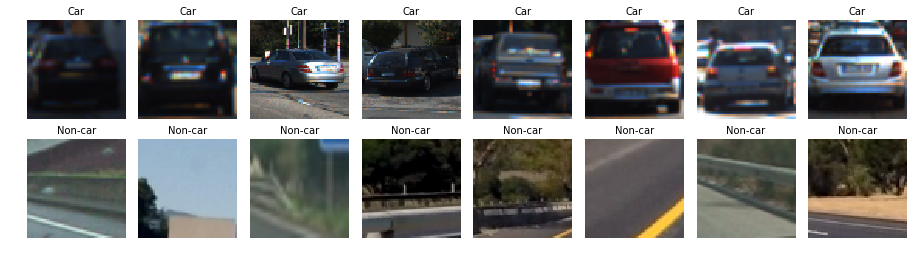

In [2]:
fig, axs = plt.subplots(2, 8, figsize=(16, 4))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Cars
for i in np.arange(8):
    img_name = cars[np.random.randint(len(cars))]
    img = cv2.imread(img_name)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('Car', fontsize=10)
    axs[i].imshow(img)

# Non-cars
for i in np.arange(8,16):
    img_name = notcars[np.random.randint(len(notcars))]
    img = cv2.imread(img_name)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('Non-car', fontsize=10)
    axs[i].imshow(img)


### Code section 3: Feature extraction methods (from course lessons)

In [3]:
# Use HOG (Histogram of Oriented Gradient) feature extraction
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

### Code section 4: Display HOG (Histogram of Oriented Gradients) representations of training images
Below I show for examples of cars and non-cars, each, coupled with their HOG image representations.

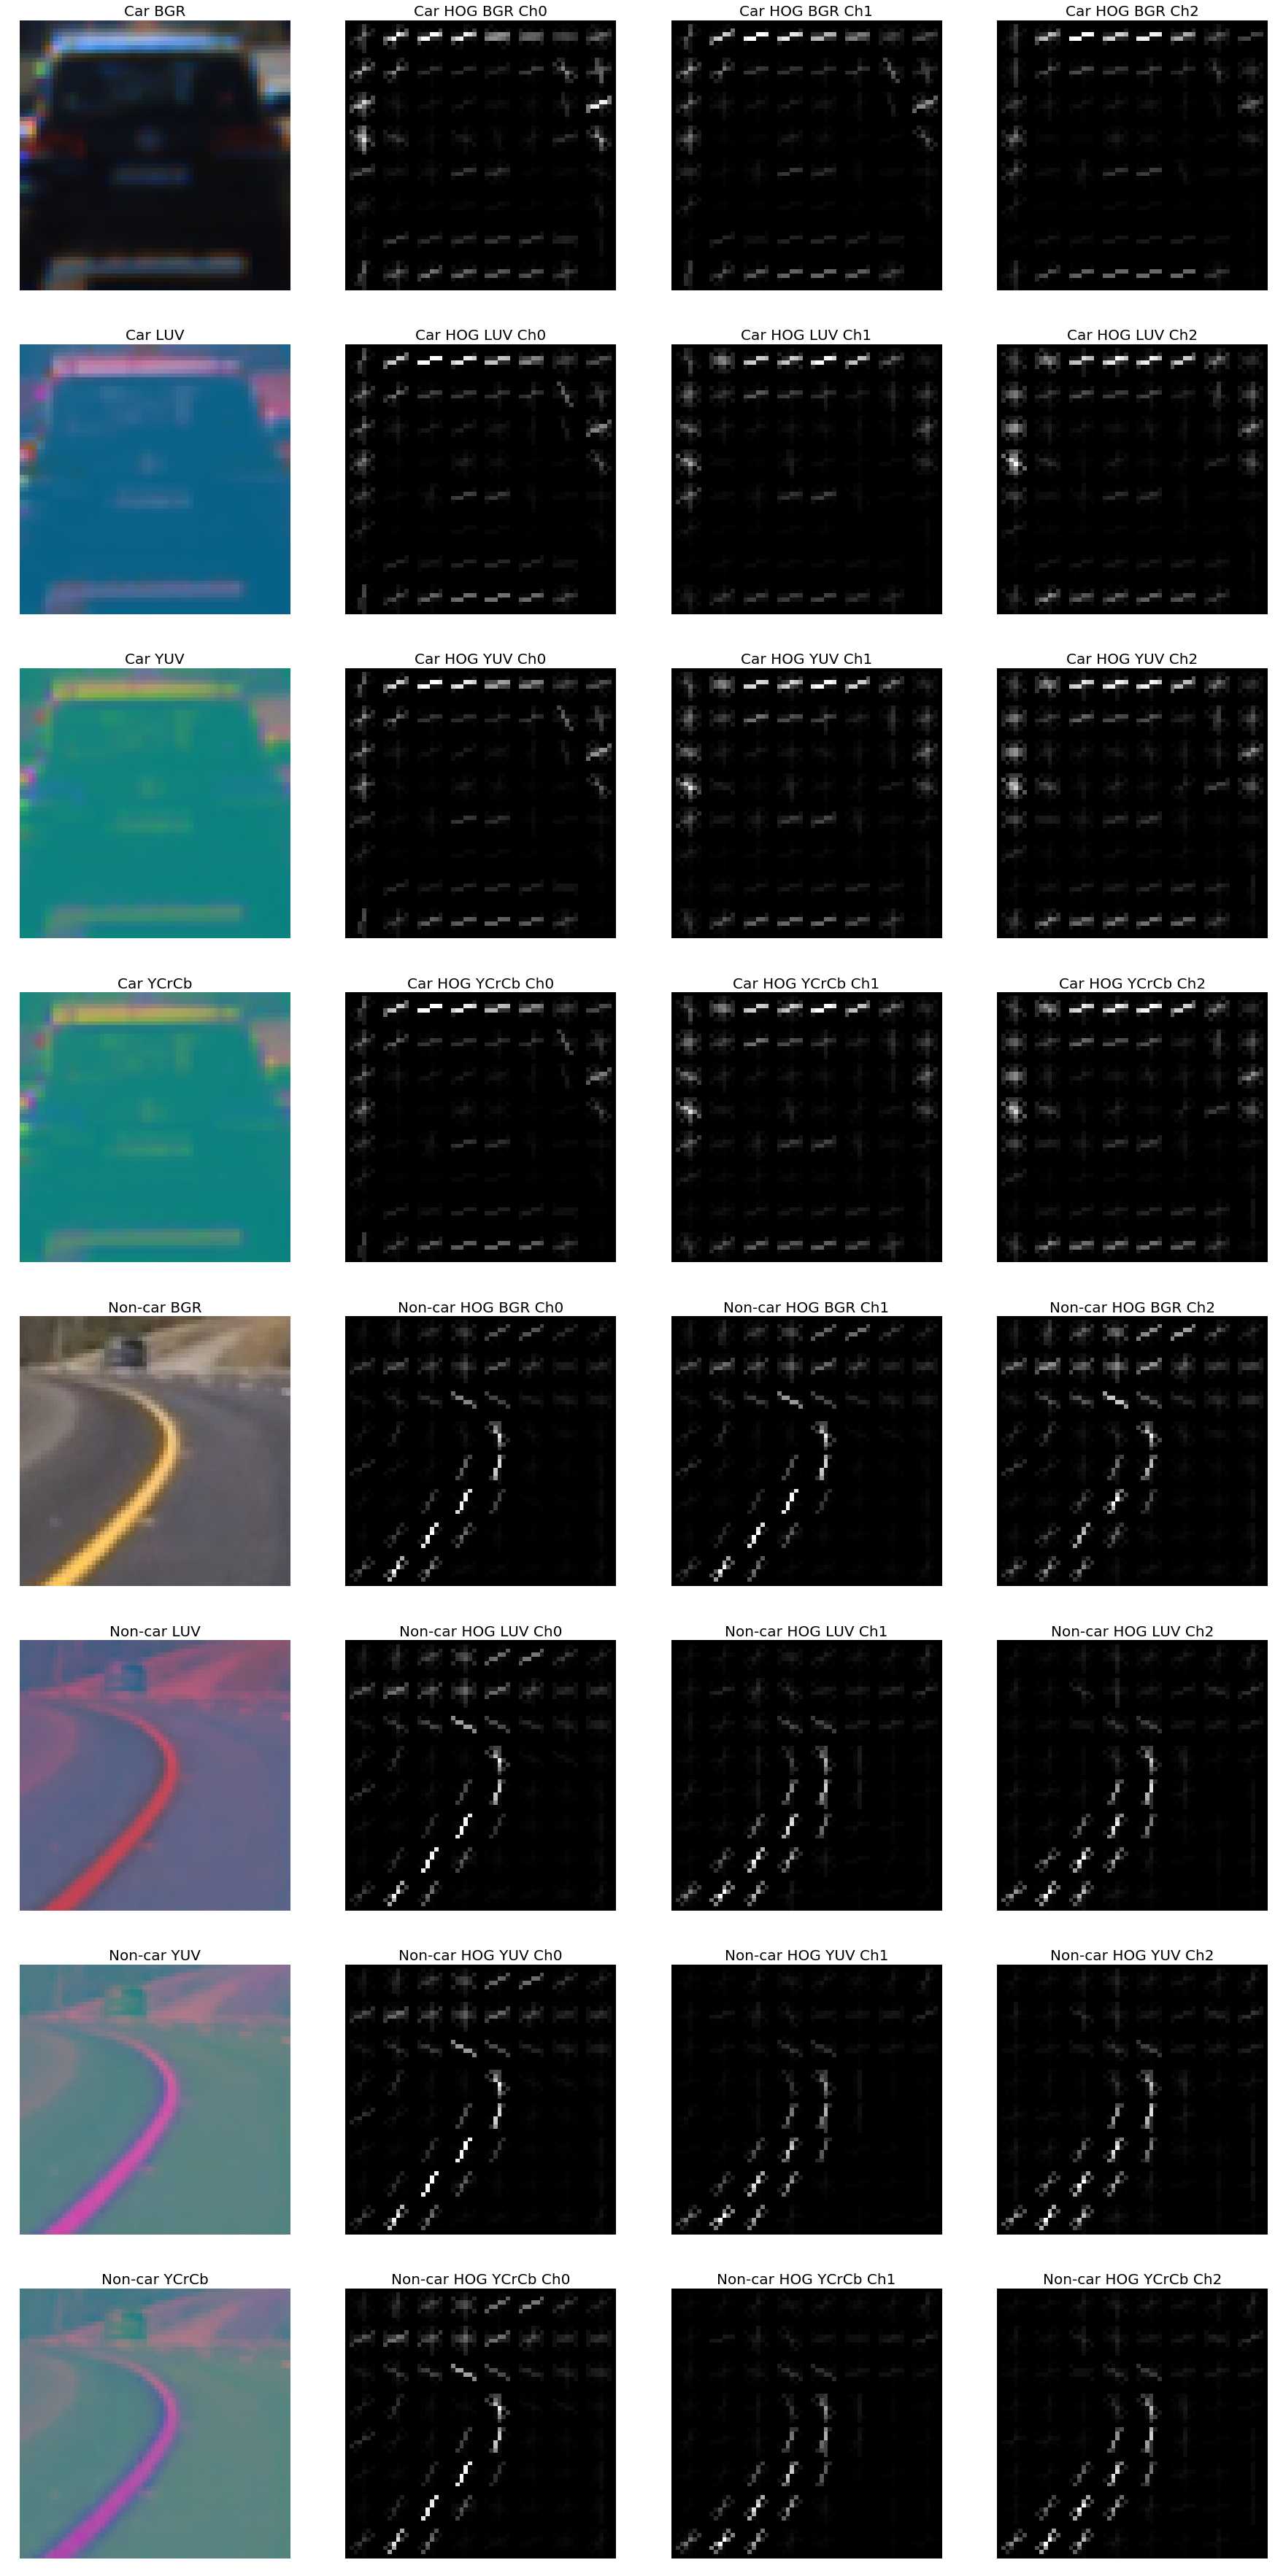

In [4]:
def show_car_img(img, i, label, is_gray):
    axs[i].axis('off')
    axs[i].set_title(label, fontsize=20)
    if is_gray:
        axs[i].imshow(img, cmap='gray')
    else:
        axs[i].imshow(img)

def show_car_and_hog(img_name, i, car_label, cspace, color_name):
        img = cv2.imread(img_name)
        
        img = cv2.cvtColor(img,cspace)

        show_car_img(img, i, car_label + ' ' + color_name, False)
        i += 1

        for channel in range(3):
            _, hog_img = get_hog_features(img[:,:,channel], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
            show_car_img(hog_img, i, car_label + ' HOG ' + color_name + ' Ch' + str(channel), True)
            i += 1

fig, axs = plt.subplots(8, 4, figsize=(32, 64))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

orient = 11 
# pix_per_cell = 16 
pix_per_cell = 8 
cell_per_block = 2

# Cars and Non-cars, interspersed
i=0
car_img_name = cars[np.random.randint(len(cars))]
noncar_img_name = notcars[np.random.randint(len(notcars))]
while i < 32:
    cspace = cv2.COLOR_RGB2BGR
    show_car_and_hog(car_img_name, i, 'Car', cspace, 'BGR')
    i += 4
    cspace = cv2.COLOR_RGB2LUV
    show_car_and_hog(car_img_name, i, 'Car', cspace, 'LUV')
    i += 4
    cspace = cv2.COLOR_RGB2YUV
    show_car_and_hog(car_img_name, i, 'Car', cspace, 'YUV')
    i += 4
    cspace = cv2.COLOR_RGB2YCrCb
    show_car_and_hog(car_img_name, i, 'Car', cspace, 'YCrCb')
    i += 4
    cspace = cv2.COLOR_RGB2BGR
    show_car_and_hog(noncar_img_name, i, 'Non-car', cspace, 'BGR')
    i += 4
    cspace = cv2.COLOR_RGB2LUV
    show_car_and_hog(noncar_img_name, i, 'Non-car', cspace, 'LUV')
    i += 4
    cspace = cv2.COLOR_RGB2YUV
    show_car_and_hog(noncar_img_name, i, 'Non-car', cspace, 'YUV')
    i += 4
    cspace = cv2.COLOR_RGB2YCrCb
    show_car_and_hog(noncar_img_name, i, 'Non-car', cspace, 'YCrCb')
    i += 4

### Code section 5: Methods for extracting features from images

In [5]:
spatial_size=(32, 32)
hist_bins=32
hist_range=(0, 256)

# Define a function to extract features from a list of image locations
# This function could also be used to call bin_spatial() and color_hist() (as in the lessons) to extract
# flattened spatial color features and color histogram features and combine them all (making use of StandardScaler)
# to be used together for classification
def extract_features(imgs, cspace='LUV', orient=orient, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL'):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
        file_features = []
        
        # Append the new feature vector to the features list
        file_features.append(hog_features)

        global spatial_size, hist_bins

        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        file_features.append(spatial_features)
        
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins)
        file_features.append(hist_features)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate(file_features))
       
    # Return list of feature vectors
    return features

### Code section 6: Extract features from the training data

In [6]:
colorspace = 'YUV'
hog_channel = 'ALL'

t = time.time()
print('Training classifier...')

print('Extracting car features...')
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
print('Extracting notcar features...')
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)  

# Fit a per-column scaler - this will be necessary if combining different types of features (HOG + color_hist/bin_spatial)
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Training classifier...
Extracting car features...
Extracting notcar features...
82.14 Seconds to extract HOG features...
Using: 11 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 9636


### Code section 7: Train and validate a LinearSVC

In [7]:
# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts:     ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

7.12 Seconds to train SVC...
Test Accuracy of SVC =  0.9918
My SVC predicts:      [ 0.  0.  1.  1.  0.  0.  0.  0.  1.  1.]
For these 10 labels:  [ 0.  0.  1.  1.  0.  0.  0.  0.  1.  1.]
0.00175 Seconds to predict 10 labels with SVC


### Code section 8: Method for detecting and locating features using sliding windows

In [8]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Timing output util method
t1 = None
def time_since(comment='No comment'):
    global t1
    t2 = time.time()
    if t1 is not None:
        print(round(t2 - t1, 2), comment)
    t1 = t2

# Define a single function that can extract features using hog sub-sampling and make predictions
# def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
#               pix_per_cell, cell_per_block):
# def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block):
        
    # array of rectangles where cars were detected
    rectangles = []
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
            
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
                        
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
           
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((hog_features, spatial_features, hist_features)).reshape(1, -1))    
#             test_features = X_scaler.transform((hog_features).reshape(1, -1))
                        
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    
    return rectangles

### Code section 9: Test code for finding the average box in a list of boxes

In [9]:
from numpy import mean

boxes_list = []
boxes = []
max_boxes = 3
for j in range(3):
    for i in range(8):
        box = [[i,i],[20-i,20-i]]
        if i >= max_boxes:
            boxes = boxes[1:]
        boxes.append(box)
#         print(boxes)
        avg_box = tuple(mean(boxes, axis=0))
#         print('top_left:',avg_box[0],'bottom_right:',avg_box[1])
    boxes_list.append(boxes)
    
# print(boxes_list)

flattened_boxes_list = []
for boxes in boxes_list:
    flattened_boxes_list.extend(boxes)
    
# print(flattened_boxes_list)

### Code section 10: CarHistory class: Detect cars found in recent frames

In [10]:
# The CarHistory class holds the rectangles detected by find_cars
# for the previous n video frames. These rectangles are combined
# and the sum is passed to the heat map detection and thresholding
# methods.
#
# This history is also used to ignore spurious false-positive cars 
# that appear only in one or two frames.
class CarHistory:
    def __init__(self):
        self.max_frames = 10 # Max number of frames to keep track of
        self.frame_history = [] # Array of rectangles for the latest frames
    
    # For each frame, add the cars that were found. The 'cars'
    # param is the raw list of rectangles where cars were identified by 
    # the classifier (using the find_cars() method)
    def add_cars(self, cars):
        if len(self.frame_history) >= self.max_frames:
            self.frame_history = self.frame_history[1:]
        self.frame_history.append(cars)
    
    # Return a flat list of cars (boxes) for the previous n frames
    def get_cars(self):
        cars = []
        for frame_cars in self.frame_history:
            cars.extend(frame_cars)
        return cars
    
    def get_frame_count(self):
        return len(self.frame_history)

carHistory = None

### Code section 11: Heatmap, threshold, and box-drawing utility methods

In [11]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def draw_labeled_bboxes(img, labels):
        
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    
    # Return the image
    return img

### Code section 12: Image annotation method

In [12]:
def annotate_image(img, show_images=False):
            
    rectangles = []
    
    for scale in scale_list:
        rects = find_cars(img, ystart, ystop, scale, 
                          svc, X_scaler, orient, pix_per_cell, cell_per_block)
        rectangles.extend(rects)

    heat = np.zeros_like(img[:,:,0]).astype(np.float32)

    # Add the rects found for the current frame to the CarHistory object
    # so that it can produce a smooth rectangle for each car that is 
    # consistent from one frame to the next, and (hopefully) free of
    # spurious false-positive results.
    global carHistory
    if carHistory is not None:
        carHistory.add_cars(rectangles)

        # Add heat to each box in box list
        heat = add_heat(heat, carHistory.get_cars())

        # Apply threshold to help remove false positives
        heat = apply_threshold(heat, carHistory.get_frame_count()//2)
    else:
        # Add heat to each box in box list
        heat = add_heat(heat, rectangles)

        # Apply threshold to help remove false positives
        heat = apply_threshold(heat, 1)

    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    if show_images:
        print(len(rectangles), 'rectangles found')
        
        img_rects = draw_boxes(img, rectangles)

        fig = plt.figure(figsize=(50,100))
        plt.subplot(131)
        plt.imshow(img_rects)
        plt.title('All Positions', fontsize=20)
        plt.subplot(132)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Thresholded Heat Map', fontsize=20)
        plt.subplot(133)
        plt.imshow(draw_img)
        plt.title('Thresholded Car Positions', fontsize=20)
        fig.tight_layout()
        
    return draw_img


### Code section 13: 

21 rectangles found
0 rectangles found
3 rectangles found
25 rectangles found
15 rectangles found
22 rectangles found


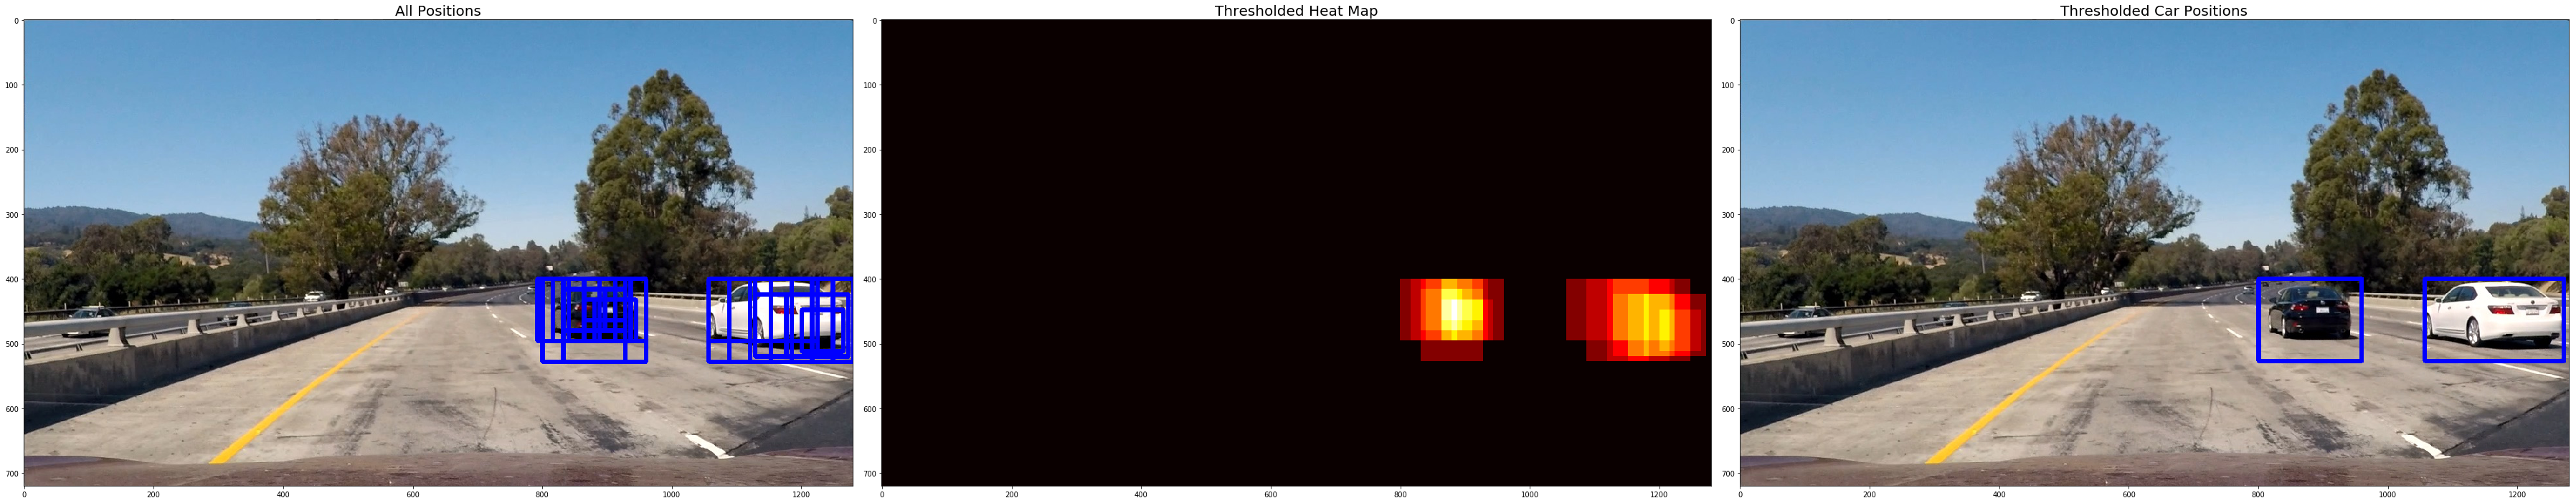

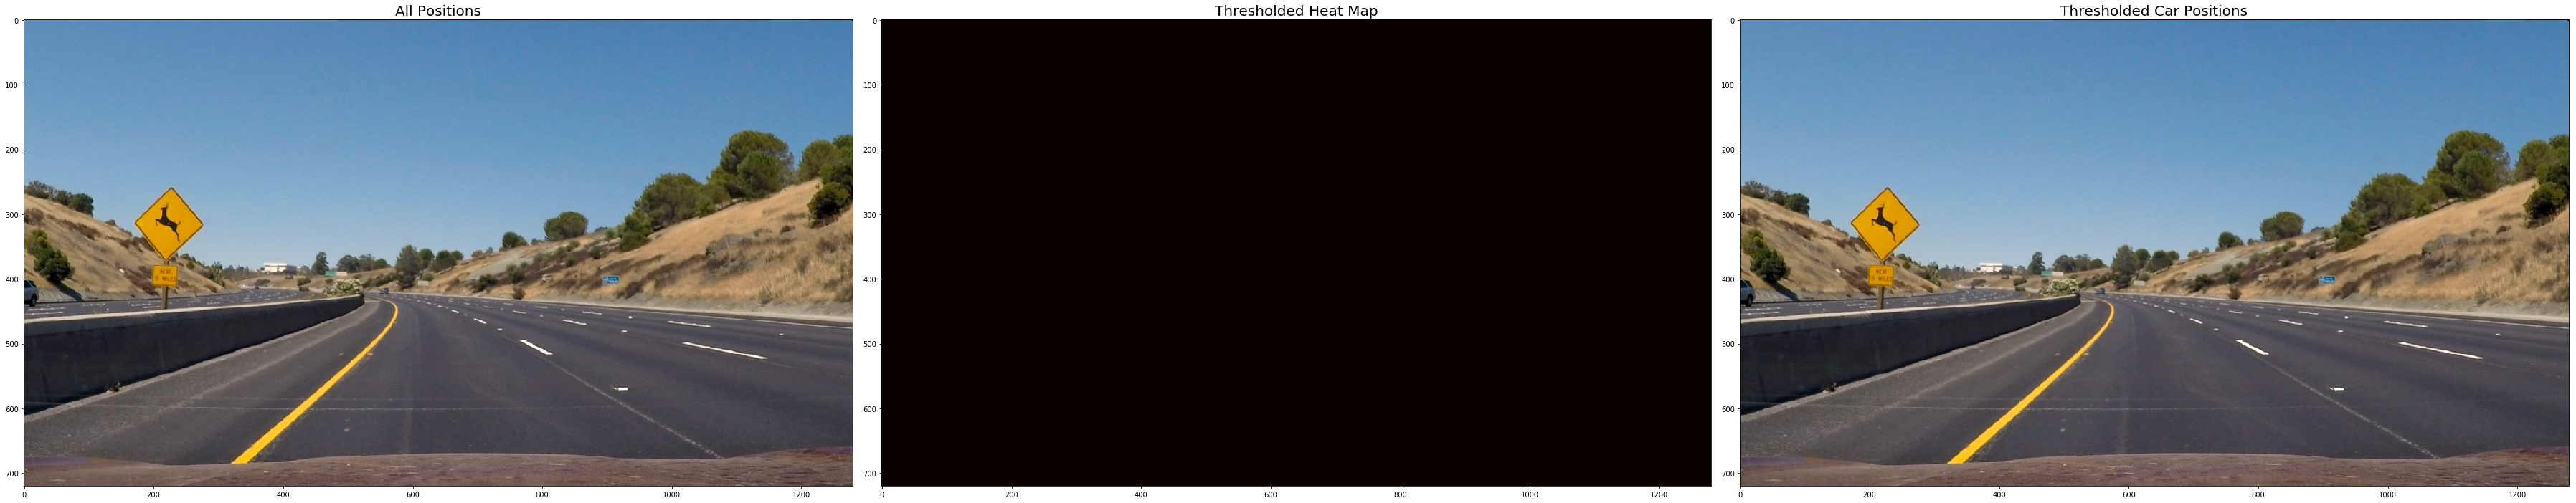

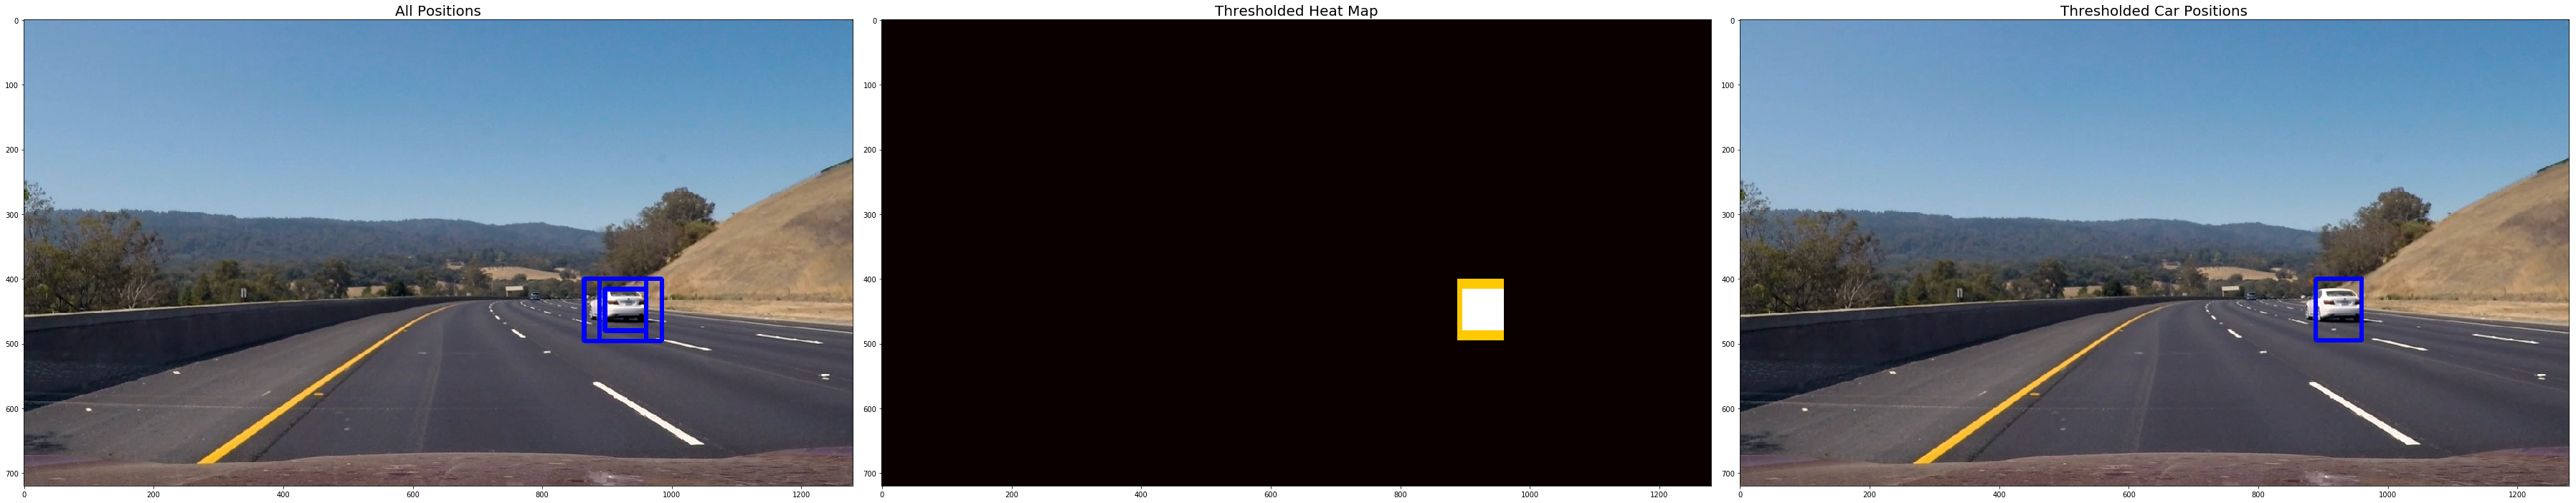

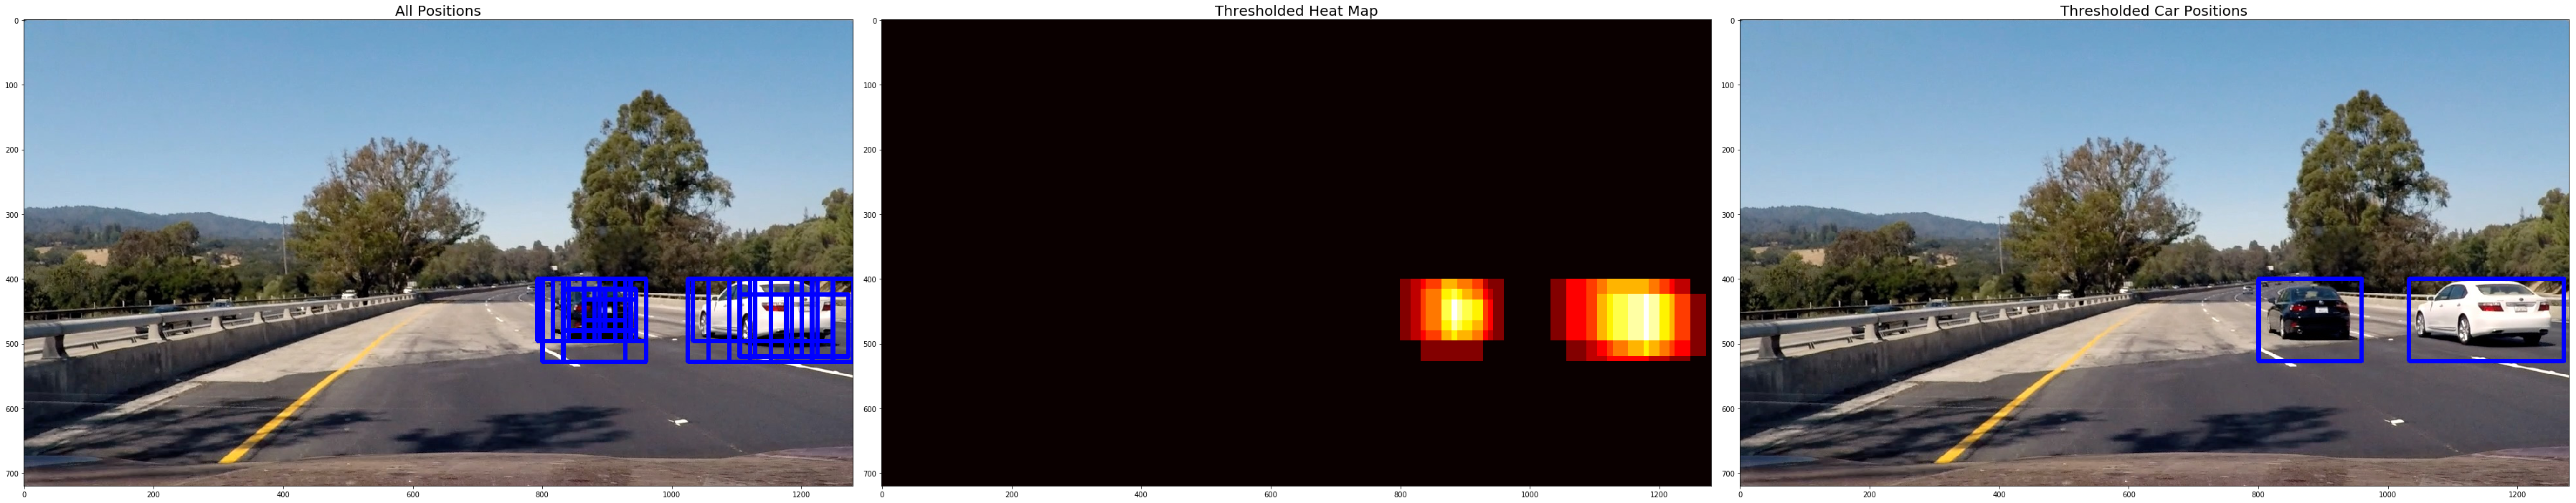

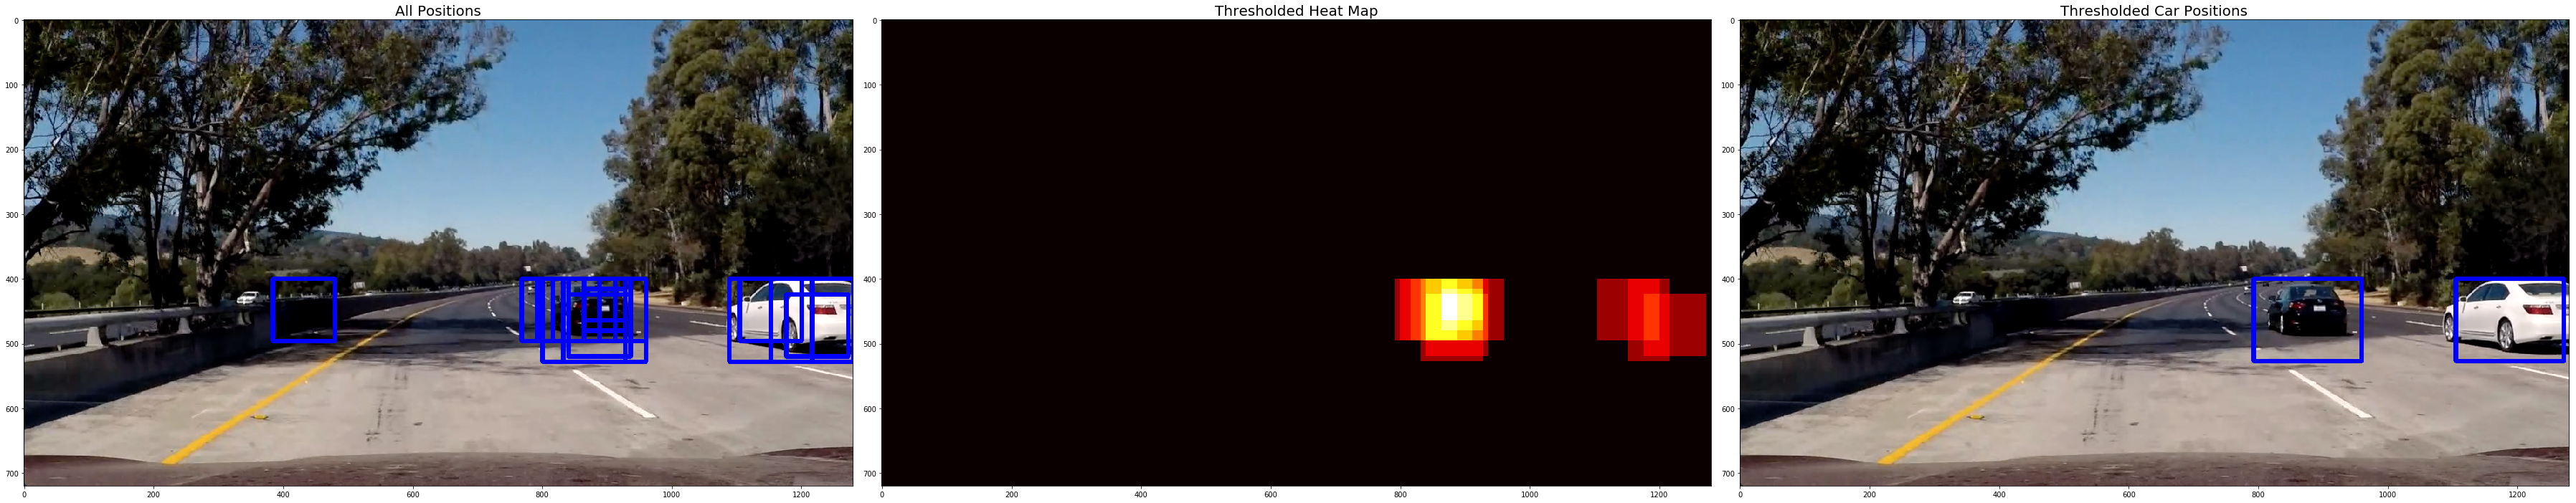

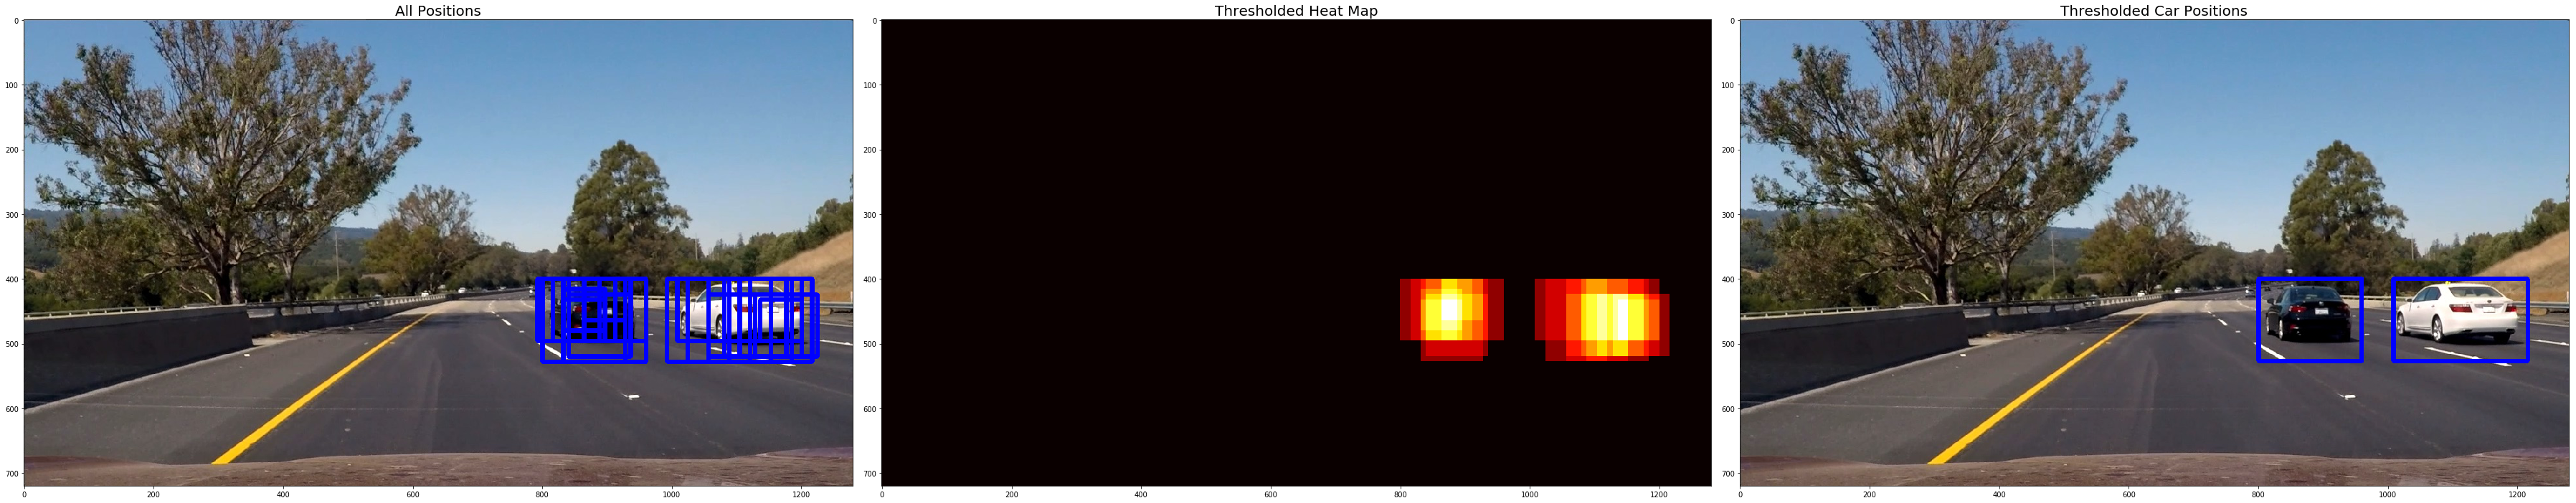

In [13]:
ystart = 400
ystop = 656
scale_list = [1, 1.5, 2, 3]

images = sorted(glob.glob('test_images/*.jpg'))
for img_name in images:
    test_img = mpimg.imread(img_name)
        
    annotate_image(test_img, show_images=True)

### Code section 14: Process the video files
Iterate over all frames in an input video, drawing a single box around each car that is detected.

Uses pickle to acquire an existing classifier (svc) and scaler (X_scaler) along with other parameters used during the training process.

In [14]:
# MoviePy video annotation will call this function
def annotate_frame(img):
    return annotate_image(img, show_images=False)

def annotate_video(input_file, output_file):
    
    video = VideoFileClip(input_file)
    
    # Initialize a new CarHistory instance for tracking cars 
    # across the previous n frames and calculating the average 
    # cars for smoothness
    global carHistory
    carHistory = CarHistory()
    
    annotated_video = video.fl_image(annotate_frame)
    annotated_video.write_videofile(output_file, audio=False)

# Annotate the test video
annotate_video('test_video.mp4', 'output_images/test_video_out.mp4')

# Annotate the project video
annotate_video('project_video.mp4', 'output_images/project_video_out.mp4')

[MoviePy] >>>> Building video output_images/test_video_out.mp4
[MoviePy] Writing video output_images/test_video_out.mp4


 97%|█████████▋| 38/39 [01:00<00:01,  1.60s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/test_video_out.mp4 

[MoviePy] >>>> Building video output_images/project_video_out.mp4
[MoviePy] Writing video output_images/project_video_out.mp4


100%|█████████▉| 1260/1261 [35:01<00:01,  1.62s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_out.mp4 

